# Examine sample make-up

In [1]:
suppressMessages({library(SummarizedExperiment)
                  library(tidyverse)
                  library(ggpubr)})

## Samples after quality control

In [2]:
save_ggplots <- function(p, fn, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

### Load Caudate data

In [3]:
# Load counts and phenotype R variable
load("../../input/counts/_m/caudate_brainseq_phase3_hg38_rseGene_merged_n464.rda")
### Subset and recode
keepIndex = which((rse_gene$Dx %in% c('Control', "Schizo")) & 
                  rse_gene$Race %in% c('CAUC', 'AA'))
rse_gene = rse_gene[, keepIndex]
### Extract phenotypes
pheno_C <- colData(rse_gene) %>% as.data.frame

### Load DLPFC data

In [4]:
# Load counts and phenotype R variable
load("../../input/counts/_m/dlpfc_ribozero_brainseq_phase2_hg38_rseGene_merged_n453.rda")
### Subset and recode
keepIndex = which((rse_gene$Dx %in% c('Control', "Schizo")) & 
                  rse_gene$Race %in% c('CAUC', 'AA'))
rse_gene = rse_gene[, keepIndex]
### Extract phenotypes
pheno_D <- colData(rse_gene) %>% as.data.frame

### Load Hippocampus data

In [5]:
# Load counts and phenotype R variable
load("../../input/counts/_m/hippo_brainseq_phase2_hg38_rseGene_merged_n447.rda")
### Subset and recode
keepIndex = which((rse_gene$Dx %in% c('Control', "Schizo")) & 
                  rse_gene$Race %in% c('CAUC', 'AA'))
rse_gene = rse_gene[, keepIndex]
### Extract phenotypes
pheno_H <- colData(rse_gene) %>% as.data.frame

### Load DG data

In [6]:
# Load counts and phenotype R variable
load("../../input/counts/_m/astellas_dg_hg38_rseGene_n263.rda")
### Subset and recode
keepIndex = which((rse_gene$Dx %in% c('Control', "Schizo")) & 
                  rse_gene$Race %in% c('CAUC', 'AA'))
rse_gene = rse_gene[, keepIndex]
### Extract phenotypes
pheno_dg <- colData(rse_gene) %>% as.data.frame

### Merge data

In [7]:
allCols <- intersect(intersect(intersect(colnames(pheno_C), colnames(pheno_D)), 
                               colnames(pheno_H)), 
                     colnames(pheno_dg))
pheno = rbind(pheno_C[, allCols], pheno_D[, allCols], 
              pheno_H[, allCols], pheno_dg[, allCols]) %>% 
    filter(Age > 13) %>% mutate(Race=gsub("CAUC", "EA", Race))

## STRUCTURE analysis

In [8]:
ancestry = data.table::fread("../../input/ancestry_structure/structure.out_ancestry_proportion_raceDemo_compare")
ancestry %>% head()

id,Afr,Eur,group
<chr>,<dbl>,<dbl>,<chr>
Br2374,0.007,0.993,CAUC
Br1857,0.001,0.999,CAUC
Br1306,0.759,0.241,AA
Br2605,0.644,0.356,AA
Br1802,0.840,0.160,AA
Br2565,0.005,0.995,CAUC


In [9]:
ancestry %>% mutate_if(is.character, as.factor) %>%
    group_by(group) %>% summarize(AA=mean(Afr), EA=mean(Eur))

group,AA,EA
<fct>,<dbl>,<dbl>
AA,0.782219451,0.2177805
CAUC,0.007510536,0.9924895


In [10]:
ancestry %>% inner_join(pheno, by=c("id"="BrNum")) %>%
    filter(Age > 17, Dx == "Control") %>% select(group, Afr, Eur) %>% 
    mutate_if(is.character, as.factor) %>% distinct %>%
    group_by(group) %>% 
    summarize(AA_mean=mean(Afr), AA_sd=sd(Afr), AA_max=max(Afr), AA_min=min(Afr),
              EA_mean=mean(Eur), EA_sd=sd(Eur), EA_max=max(Eur), EA_min=min(Eur))

group,AA_mean,AA_sd,AA_max,AA_min,EA_mean,EA_sd,EA_max,EA_min
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AA,0.78962609,0.10611682,0.999,0.381,0.2103739,0.10611682,0.619,0.001
CAUC,0.03087879,0.02997578,0.156,0.001,0.9691212,0.02997578,0.999,0.844


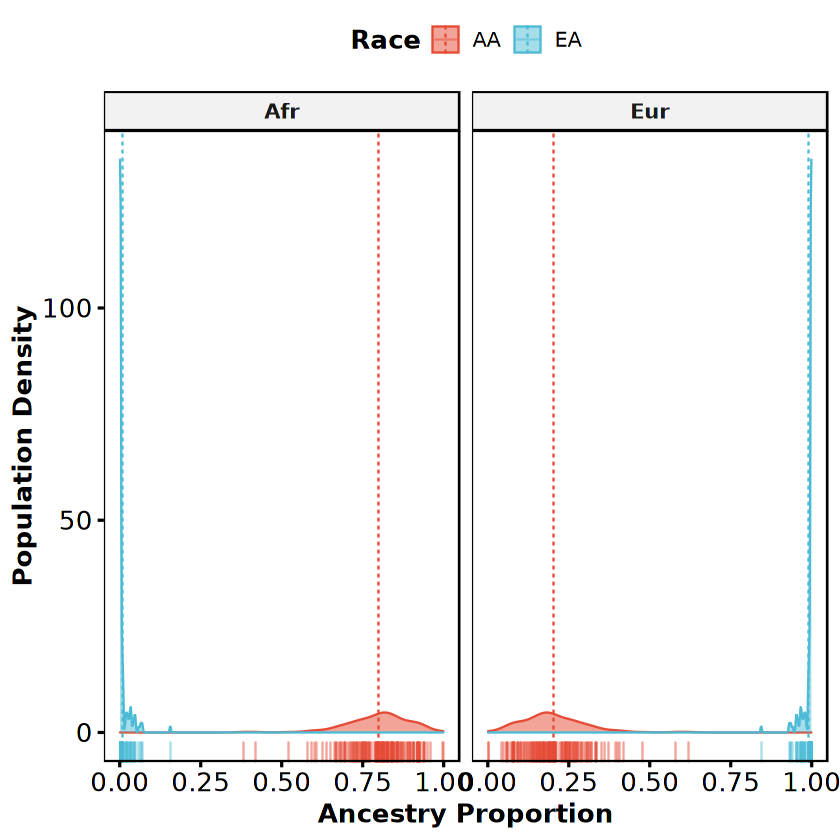

In [11]:
bxp = ancestry %>% inner_join(pheno, by=c("id"="BrNum")) %>%
    filter(Age > 17, Dx == "Control") %>% select(id, Race, Afr, Eur) %>%
    mutate_if(is.character, as.factor) %>% distinct %>%
    pivot_longer(-c("Race", "id"), names_to="Ancestry", values_to="Proportion") %>% 
    ggdensity(x="Proportion", color="Race", fill="Race", facet.by="Ancestry", 
              ncol=2, rug=TRUE, add="mean", palette="npg", ylab="Population Density", 
              xlab="Ancestry Proportion", panel.labs.font=list(face='bold'), 
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    font("xy.title", face="bold") + font("legend.title", face="bold")
save_ggplots(bxp, "ancestry_structure_distribution", 10, 5)
bxp

## eQTL analysis

In [12]:
pheno %>% dim

[1] 1334   21

In [13]:
print(paste("There are", unique(pheno$BrNum) %>% length, "unique BrNum."))

[1] "There are 509 unique BrNum."


In [14]:
pheno %>% select(BrNum, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region) %>% count()

Region,n
<fct>,<int>
Caudate,400
DLPFC,378
DentateGyrus,161
HIPPO,395


In [15]:
pheno %>% select(BrNum, Race) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Race) %>% count()

Race,n
<fct>,<int>
AA,256
EA,253


In [16]:
pheno %>% select(BrNum, Race, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region, Race) %>% count()

Region,Race,n
<fct>,<fct>,<int>
Caudate,AA,206
Caudate,EA,194
DLPFC,AA,204
DLPFC,EA,174
DentateGyrus,AA,78
DentateGyrus,EA,83
HIPPO,AA,213
HIPPO,EA,182


In [17]:
pheno %>% select(BrNum, Sex, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region, Sex) %>% count()

Region,Sex,n
<fct>,<fct>,<int>
Caudate,F,126
Caudate,M,274
DLPFC,F,121
DLPFC,M,257
DentateGyrus,F,48
DentateGyrus,M,113
HIPPO,F,126
HIPPO,M,269


In [18]:
pheno %>% group_by(Region) %>% 
  summarise_at(vars(c("Age")), list(mean = mean, sd = sd)) 

Region,mean,sd
<chr>,<dbl>,<dbl>
Caudate,49.12390,16.05379
DLPFC,45.83574,16.49445
DentateGyrus,50.06770,15.43849
HIPPO,45.49527,16.41527


In [19]:
pheno %>% group_by(Region, Race) %>% 
  summarise_at(vars(c("Age")), list(mean = mean, sd = sd)) 

Region,Race,mean,sd
<chr>,<chr>,<dbl>,<dbl>
Caudate,AA,48.81325,14.49676
Caudate,EA,49.45376,17.58900
DLPFC,AA,46.97896,15.34261
DLPFC,EA,44.49542,17.70090
DentateGyrus,AA,50.18423,15.53374
DentateGyrus,EA,49.95819,15.44210
HIPPO,AA,46.34080,15.61922
HIPPO,EA,44.50571,17.29140


In [20]:
pheno %>% filter(RIN != "NA") %>% mutate("RIN"=as.numeric(unlist(RIN))) %>% 
    group_by(Region) %>% summarise_at(vars(c("RIN")), list(mean = mean, sd = sd)) 

Region,mean,sd
<chr>,<dbl>,<dbl>
Caudate,7.861000,0.8648983
DLPFC,7.699471,0.9340876
DentateGyrus,5.208403,1.1871187
HIPPO,7.616962,1.0311104


In [21]:
pheno %>% filter(RIN != "NA") %>% mutate("RIN"=as.numeric(unlist(RIN))) %>% 
    group_by(Region, Race) %>% summarise_at(vars(c("RIN")), list(mean = mean, sd = sd)) 

Region,Race,mean,sd
<chr>,<chr>,<dbl>,<dbl>
Caudate,AA,7.859709,0.8416464
Caudate,EA,7.862371,0.8911055
DLPFC,AA,7.678922,0.9445184
DLPFC,EA,7.723563,0.9238440
DentateGyrus,AA,5.206349,1.2062837
DentateGyrus,EA,5.210714,1.1760765
HIPPO,AA,7.604225,1.0509344
HIPPO,EA,7.631868,1.0101014


## Adult individuals for expression related analysis

In [22]:
pheno = pheno %>% filter(Age > 17, Dx == "Control")
pheno %>% dim

[1] 785  21

In [23]:
print(paste("There are", unique(pheno$BrNum) %>% length, "unique BrNum."))

[1] "There are 292 unique BrNum."


In [24]:
pheno %>% select(BrNum, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region) %>% count()

Region,n
<fct>,<int>
Caudate,240
DLPFC,212
DentateGyrus,90
HIPPO,243


In [25]:
pheno %>% select(BrNum, Race) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Race) %>% count()

Race,n
<fct>,<int>
AA,151
EA,141


In [26]:
pheno %>% select(BrNum, Race, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region, Race) %>% count()

Region,Race,n
<fct>,<fct>,<int>
Caudate,AA,122
Caudate,EA,118
DLPFC,AA,123
DLPFC,EA,89
DentateGyrus,AA,47
DentateGyrus,EA,43
HIPPO,AA,133
HIPPO,EA,110


In [27]:
pheno %>% select(BrNum, Sex, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region, Sex) %>% count()

Region,Sex,n
<fct>,<fct>,<int>
Caudate,F,71
Caudate,M,169
DLPFC,F,66
DLPFC,M,146
DentateGyrus,F,26
DentateGyrus,M,64
HIPPO,F,74
HIPPO,M,169


In [28]:
pheno %>% group_by(Region) %>% 
  summarise_at(vars(c("Age")), list(mean = mean, sd = sd)) 

Region,mean,sd
<chr>,<dbl>,<dbl>
Caudate,48.31150,15.84692
DLPFC,45.16991,14.76717
DentateGyrus,47.88311,15.02380
HIPPO,44.56724,14.73045


In [29]:
pheno %>% group_by(Region, Race) %>% 
  summarise_at(vars(c("Age")), list(mean = mean, sd = sd)) 

Region,Race,mean,sd
<chr>,<chr>,<dbl>,<dbl>
Caudate,AA,45.63770,14.72979
Caudate,EA,51.07593,16.53588
DLPFC,AA,44.12511,14.97092
DLPFC,EA,46.61386,14.43996
DentateGyrus,AA,45.85043,16.32827
DentateGyrus,EA,50.10488,13.28980
HIPPO,AA,43.30015,14.73609
HIPPO,EA,46.09927,14.64404


In [30]:
pheno %>% filter(RIN != "NA") %>% mutate("RIN"=as.numeric(unlist(RIN))) %>% 
    group_by(Region) %>% summarise_at(vars(c("RIN")), list(mean = mean, sd = sd)) 

Region,mean,sd
<chr>,<dbl>,<dbl>
Caudate,7.850000,0.7956997
DLPFC,7.699057,0.8803807
DentateGyrus,5.315152,1.2186048
HIPPO,7.735391,0.9668378


In [31]:
pheno %>% filter(RIN != "NA") %>% mutate("RIN"=as.numeric(unlist(RIN))) %>% 
    group_by(Region, Race) %>% summarise_at(vars(c("RIN")), list(mean = mean, sd = sd)) 

Region,Race,mean,sd
<chr>,<chr>,<dbl>,<dbl>
Caudate,AA,7.829508,0.7993477
Caudate,EA,7.871186,0.7947587
DLPFC,AA,7.696748,0.8851169
DLPFC,EA,7.702247,0.8787876
DentateGyrus,AA,5.447368,1.2173824
DentateGyrus,EA,5.135714,1.2190507
HIPPO,AA,7.715038,0.9754173
HIPPO,EA,7.760000,0.9602370


### Pie chart

In [71]:
plot_pie <- function(tissue){
    pie = pheno %>% mutate_if(is.character, as.factor) %>% group_by(Region, Race) %>%
        count %>% as.data.frame %>% group_by(Region) %>%
        transmute(Race, Percent = round(n/sum(n)*100, 1)) %>%
        mutate(Labels=paste0(Race, " (", Percent, "%)")) %>% filter(Region == tissue) %>%
        ggpie("Percent", label="Labels", fill="Race", color="white", palette="npg", 
              lab.pos="in", lab.font=c(8, "bold", "white"),
              ggtheme=theme_pubr(base_size=20, legend="none"))
    return(pie)
}

In [76]:
## Get and annotate plot
cc_pie = annotate_figure(plot_pie("Caudate"), 
                         top = text_grob("Caudate", face = "bold", size = 26))
gg_pie = annotate_figure(plot_pie("DentateGyrus"), 
                         top = text_grob("Dentate Gyrus", face = "bold", size = 26))
dd_pie = annotate_figure(plot_pie("DLPFC"), 
                         top = text_grob("DLPFC", face = "bold", size = 26))
hh_pie = annotate_figure(plot_pie("HIPPO"), 
                         top = text_grob("Hippocampus", face = "bold", size = 26))
## Arrange figure
figure <- ggarrange(cc_pie, gg_pie, dd_pie, hh_pie, ncol = 2, nrow = 2)
save_ggplots(figure, "ancestry_piecharts", 10, 10)
figure

## Reproducibility Information

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()